### EDA 2019


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = SparkSession.builder.appName('2019EDA').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [4]:
df_2019 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/2019", inferSchema=True, header=True)
# figure out how to read in shp file msca-bdp-student-gcs/bdp-rideshare-project/neighborhoods/shp files
df_2019.printSchema()
#df_weather.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- Additional Charges: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Shared Trip Authorized: string (nullable = true)
 |-- Trips Pooled: integer (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)
 |-- Dropoff

In [5]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_2019.rdd.getNumPartitions()

150

In [6]:
displaypartitions(df_2019)

Partitions: 150


+-----------+------+
|partitionId| count|
+-----------+------+
|        149|441790|
|         45|499109|
|         22|500561|
|        122|501059|
|         71|501394|
|         40|501504|
|        101|501636|
|         31|501739|
|         10|501790|
|         27|501791|
|         44|501848|
|         13|501891|
|         75|502174|
|         58|502222|
|         14|502574|
|        126|502812|
|         26|502822|
|         54|502838|
|         30|502855|
|        118|502864|
|        143|502958|
|         62|503041|
|         36|503089|
|          6|503100|
|         18|503407|
|         35|503509|
|         88|503676|
|         92|503745|
|        131|504327|
|         83|504368|
|         17|504404|
|        110|504453|
|        134|504488|
|        130|504490|
|        135|504581|
|         57|504584|
|          5|504652|
|         80|504694|
|         53|504707|
|         49|504711|
|         79|504728|
|          9|504758|
|        139|504763|
|         84|504812|
|        105|

In [7]:
# df_2019 = df_2019.repartition(10)

In [8]:
df_2019.describe().show()

+-------+----------------+--------------------+--------------------+------------------+-----------------+--------------------+--------------------+---------------------+----------------------+------------------+------------------+------------------+------------------+----------------------+------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|summary|         Trip ID|Trip Start Timestamp|  Trip End Timestamp|      Trip Seconds|       Trip Miles| Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|              Fare|               Tip|Additional Charges|        Trip Total|Shared Trip Authorized|      Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+----------------+--------------------+--------------------+

In [9]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df_2019.select([count(when(df_2019[c].isNull(), c)).alias(c) for c in df_2019.columns]).show()

+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|Trip ID|Trip Start Timestamp|Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|Fare|Tip|Additional Charges|Trip Total|Shared Trip Authorized|Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------

<AxesSubplot:>

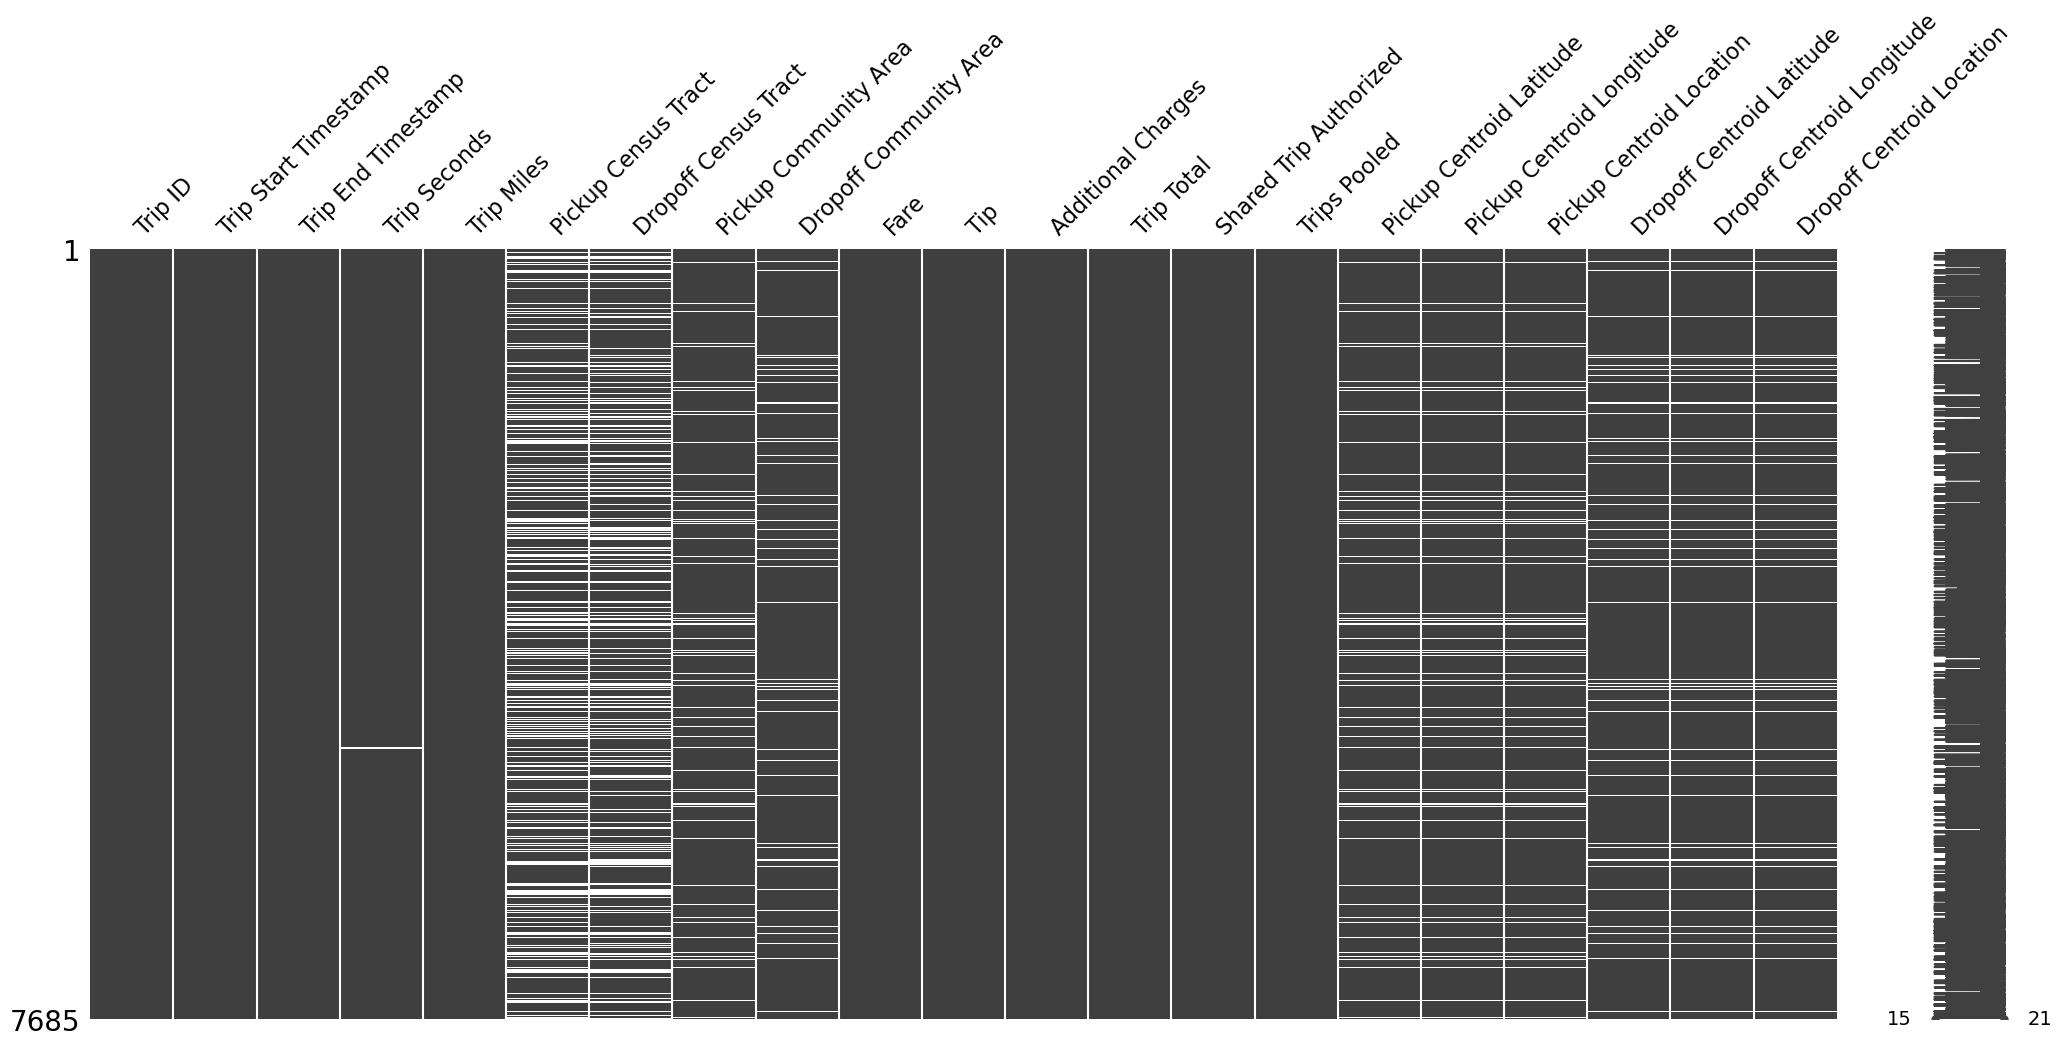

In [10]:
import missingno as msno
%matplotlib inline
msno.matrix(df_2019.sample(fraction=1/10000).toPandas())

In [11]:
#Approximate number of 2019 trips
from pyspark.sql.functions import approxCountDistinct

df_2019.select(approxCountDistinct("Trip ID", rsd = 0.01)).show()

23/11/16 17:03:54 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------------------+
|approx_count_distinct(Trip ID)|
+------------------------------+
|                      75176953|
+------------------------------+



In [12]:
# number of observations with all the data in each column
df_2019.dropna(how='any').count()

50940663

In [13]:
# Working with just data that contains full information and check for dupes
df_2019 = df_2019.dropna(how='any', subset=['Trip Start Timestamp','Trip End Timestamp','Fare','Dropoff Community Area','Pickup Community Area'])
df_2019 = df_2019.dropDuplicates()
# df_2019.count()

In [14]:
# Drop columns unlikely to be useful for analysis for speed of computation and rename columns to remove spacing for ease of code writing
#spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_2019 = df_2019.drop('Trips Pooled','Additional Charges','Shared Trip Authorized','Pickup Centroid Location','Dropoff Centroid Location')
df_2019 = df_2019.withColumnRenamed("Trip ID","ID").withColumnRenamed("Trip Start Timestamp","start_timestamp").withColumnRenamed("Trip End Timestamp","end_timestamp").withColumnRenamed("Trip Miles",\
                "miles").withColumnRenamed("Pickup Census Tract","pickup_tract").withColumnRenamed("Dropoff Census Tract","dropoff_tract").withColumnRenamed("Pickup Community Area","pickup_area"\
                ).withColumnRenamed("Dropoff Community Area","dropoff_area").withColumnRenamed("Trip Total","total").withColumnRenamed("Pickup Centroid Latitude","pickup_lat").withColumnRenamed(\
                "Pickup Centroid Longitude","pickup_lon").withColumnRenamed("Pickup Centroid Location","pickup_location").withColumnRenamed("Dropoff Centroid Latitude","dropoff_lat").withColumnRenamed(\
                "Dropoff Centroid Longitude","dropoff_lon").withColumnRenamed("Dropoff Centroid Location","dropoff_location").withColumnRenamed("Trip Seconds","seconds")
# fix datatypes
df_2019 = df_2019.withColumn('start_timestamp', F.to_timestamp(df_2019['start_timestamp'], 'MM/dd/yyyy hh:mm:ss a')).withColumn('end_timestamp', F.to_timestamp(df_2019['end_timestamp'], 'MM/dd/yyyy hh:mm:ss a'))
#df_weather = df_weather.withColumn('datetime',F.to_date(df_weather['datetime'], "yyyy-MM-dd"))


In [15]:
# add the month column
df_2019 = df_2019.withColumn('month', F.month(df_2019.start_timestamp))
df_2019 = df_2019.withColumn('day_of_month', F.dayofmonth(df_2019.start_timestamp))
df_2019 = df_2019.withColumn('hour', F.hour(df_2019.start_timestamp))
df_2019 = df_2019.withColumn('day', F.dayofweek(df_2019.start_timestamp))

In [16]:
sample_df = df_2019.sample(fraction=1/10000).toPandas().loc[:,["pickup_area","dropoff_area","total","Fare","Tip","total","miles","seconds","hour","day","month"]]

In [17]:
sample_df.head()

,pickup_area,dropoff_area,total,Fare,Tip,total,miles,seconds,hour,day,month
0,65,8,22.55,20.0,0,22.55,12.8,1574.0,23,7,1
1,3,3,5.05,2.5,0,5.05,0.5,191.0,14,2,3
2,6,28,12.55,10.0,0,12.55,4.5,1296.0,14,7,8
3,8,58,10.00,10.0,0,10.00,11.1,2156.0,19,5,1
4,71,69,12.55,10.0,0,12.55,5.3,846.0,10,4,2


In [18]:
sample_df = sample_df.dropna()
sample_df = sample_df.drop_duplicates()

In [19]:
sample_df.head()
sample_df = sample_df.drop(columns='total')

In [20]:
#import seaborn as sns
#sns.set_theme(style="ticks")
#sns.pairplot(sample_df)
#plt.show()

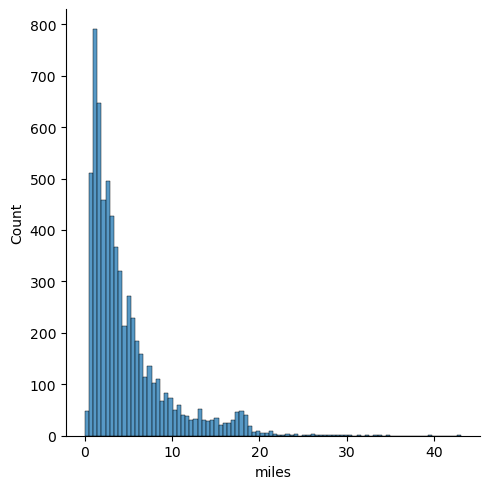

In [21]:
import seaborn as sns
sns.displot(sample_df, x="miles")

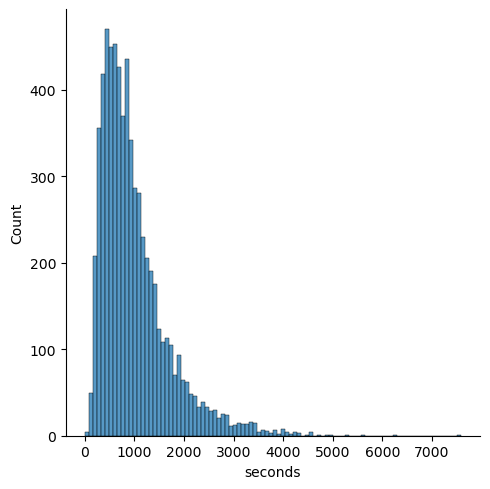

In [22]:
sns.displot(sample_df, x="seconds")

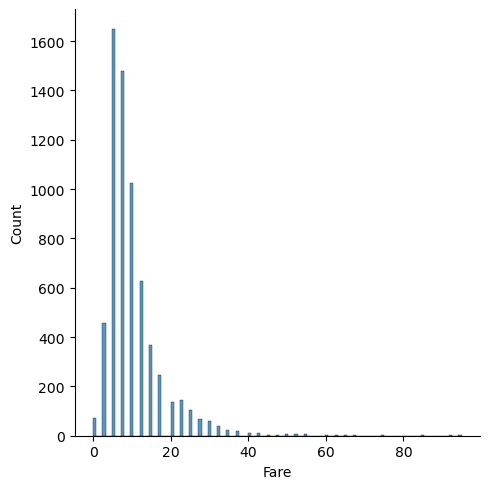

In [23]:
sns.displot(sample_df, x="Fare")

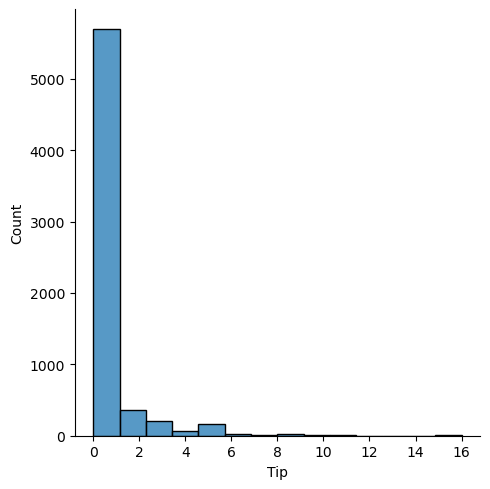

In [24]:
sns.displot(sample_df, x="Tip")

In [25]:
# get rides that occurred within hyde park
# add kenwood and woodlawn to this list - only if the other location is hyde park                    
df_hp = df_2019.filter((df_2019.pickup_area == 41) & (df_2019.dropoff_area == 41))
df_kw = df_2019.filter(((df_2019.pickup_area == 41) & (df_2019.dropoff_area == 42)) | ((df_2019.pickup_area == 42) & (df_2019.dropoff_area == 41)))
df_wl = df_2019.filter(((df_2019.pickup_area == 41) & (df_2019.dropoff_area == 39)) | ((df_2019.pickup_area == 39) & (df_2019.dropoff_area == 41)))
df_area = df_hp.union(df_kw).union(df_wl)

In [26]:
df_area.show(5)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|total|   pickup_lat|    pickup_lon|  dropoff_lat|   dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|f8cdeea6aafc3766e...|2019-01-19 15:00:00|2019-01-19 15:00:00|    247|  0.6| 17031410900|  17031410800|         41|          41| 2.5|  0| 5.05|41.7971534246|-87.5823657023|41.7979652088|-87.5896070309|    1|          19|  15|  7|
|cf4b771fa216d6876...|2019-01-19 17:30:00|2019-01-19 17:30:00|    472|  1.3| 170

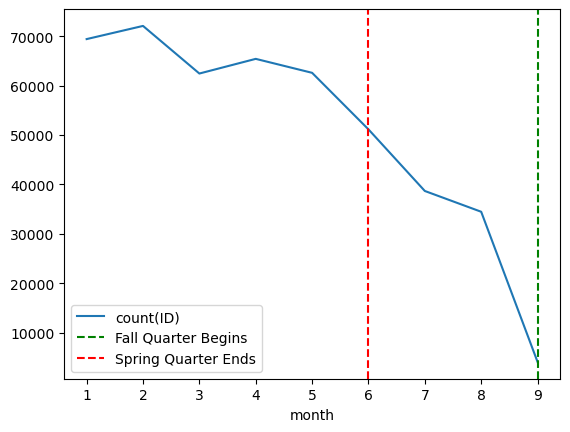

In [27]:
import matplotlib.pyplot as plt
df_count_plot = df_area.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas() #.plot(x="month",y="count(ID)")
ax = df_count_plot.plot(x="month", y="count(ID)")
ax.axvline(x=9, color='g', linestyle='--', label='Fall Quarter Begins')
ax.axvline(x=6, color='r', linestyle='--', label='Spring Quarter Ends')
plt.legend()
plt.show()

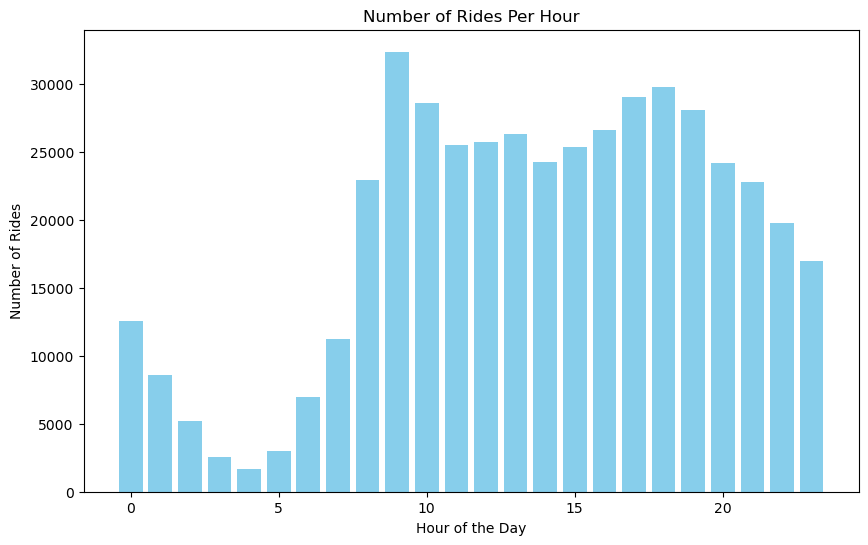

In [28]:
# rides per hour:
rides_per_hour = df_area.groupBy("hour").count().orderBy("hour")

# Convert the result to Pandas for local plotting
rides_per_hour_pd = rides_per_hour.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(rides_per_hour_pd["hour"], rides_per_hour_pd["count"], color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.title("Number of Rides Per Hour")
plt.show()

In [29]:
df_area_program = df_area.filter((df_area.Fare <= 15.0) & ((df_area.hour >= 17) | (df_area.hour < 4)))

In [30]:
from pyspark.sql.functions import approxCountDistinct

df_area_program.select(approxCountDistinct("ID", rsd = 0.05)).show()

+-------------------------+
|approx_count_distinct(ID)|
+-------------------------+
|                   199983|
+-------------------------+



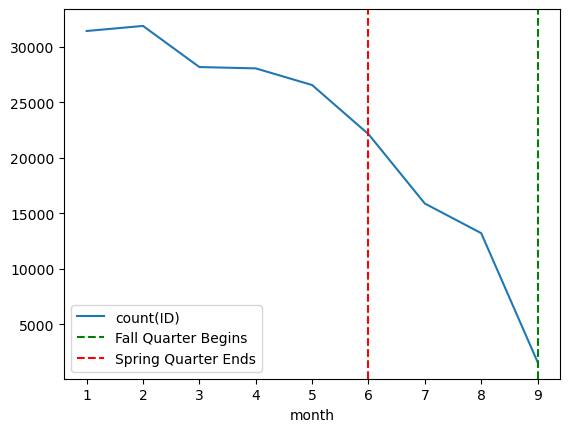

In [31]:
df_count_plot_program = df_area_program.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas() #.plot(x="month",y="count(ID)")
ax = df_count_plot_program.plot(x="month", y="count(ID)")
ax.axvline(x=9, color='g', linestyle='--', label='Fall Quarter Begins')
ax.axvline(x=6, color='r', linestyle='--', label='Spring Quarter Ends')
plt.legend()
plt.show()

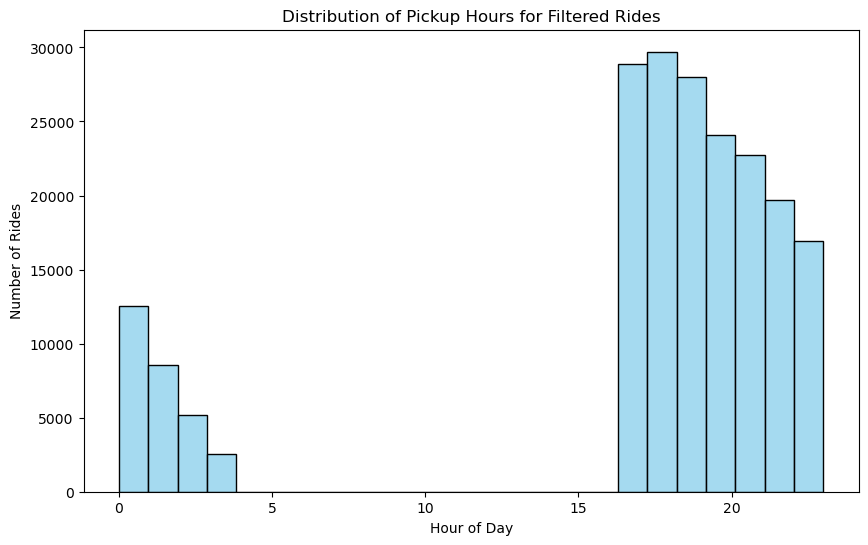

In [32]:
import seaborn as sns

df_area_program_pd = df_area_program.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_area_program_pd['hour'], bins=24, kde=False, color='skyblue')
plt.title('Distribution of Pickup Hours for Filtered Rides')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()

<AxesSubplot:xlabel='month'>

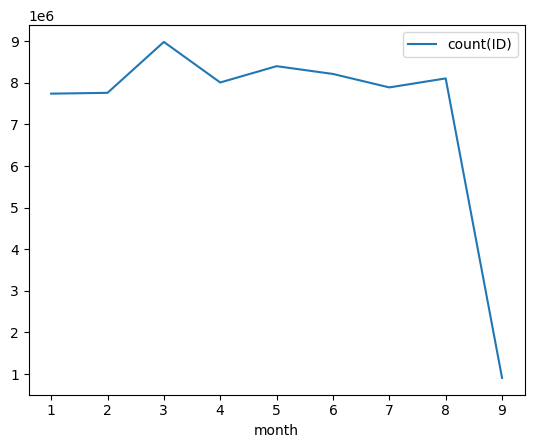

In [33]:
# basic plots for all rides (not just in the program area)
df_2019.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas().plot(x="month",y="count(ID)")

In [34]:
df_total = df_2019.groupby("pickup_area").agg({'ID':'count'}).orderBy(F.col('pickup_area').asc()).toPandas()

<Figure size 1000x1000 with 0 Axes>

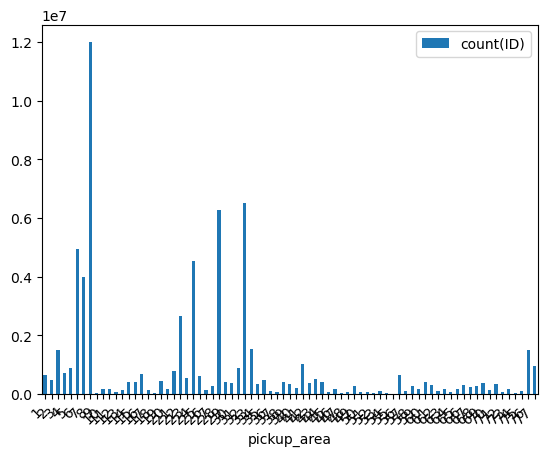

In [35]:
%matplotlib inline
plt.figure(figsize=(10, 10))
ax = df_total.plot(x="pickup_area",y="count(ID)", kind='bar')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

<AxesSubplot:xlabel='dropoff_area'>

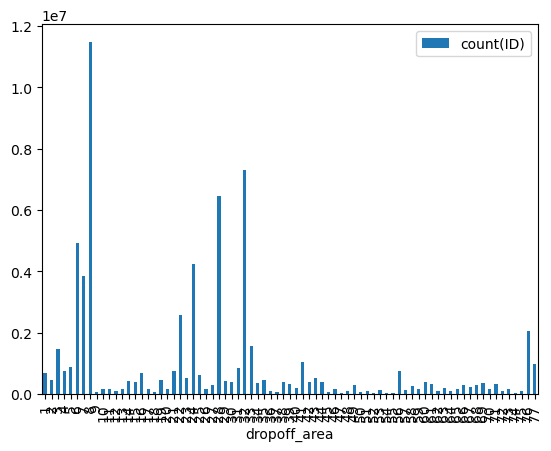

In [36]:
df_2019.groupby("dropoff_area").agg({'ID':'count'}).orderBy(F.col('dropoff_area').asc()).toPandas().plot(x="dropoff_area",y="count(ID)", kind='bar')

In [ ]:
# storing data on the bucket
df_area_program.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2019.csv")
df_2019.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2019.csv")


In [ ]:
df_2019.month.distinct()